# First, we need to be able to read the collected data. Let's write some code to do that!

In [1]:
import json
from addict import Dict
from datetime import date, datetime
from functools import cache
from typing import Any, Callable
from zipfile import ZipFile


class RawData(dict[datetime, dict[str, Any]]):
    """
    The RawData class represents a raw, time-series dataset.

    In terms of this project, there are two raw datasets being loaded. The
    lights dataset and the sensors dataset.
    """

    def __init__(self, *args, **kwargs):
        """
        The first arg should be an id - its hash will be used as the hash value
        of this object
        """
        self._id = args[0]
        super().__init__(*args[1:], **kwargs)

    def __hash__(self) -> int:
        return hash(self._id)

    @cache
    def unique_device_ids(self) -> list[int]:
        """
        Returns the ids of all devices contained in this data set in an
        **ordered** list
        """
        return sorted({int(key) for dict_ in self.values() for key in dict_})

    @cache
    def device_id_of(self, name: str) -> int:
        """
        :param name: The Hue device's name
        :return: The Hue device's id as an int
        """
        search_results = [int(device_id) for device_id, device_data in
                          next(iter(self.values())).items()
                          if name in device_data['name']]

        if len(search_results) != 1:
            raise Exception(f'Did not find a single device with name "{name}"')

        return search_results[0]

    @cache
    def timestamps(self) -> list[datetime]:
        """
        :return: A list of all timestamps in this data set - it can be used as
         the x axis when plotting data from this data set over time
        """
        return list(self.keys())

    @cache
    def devices_data(self) -> dict[int, 'DeviceData']:
        """
        :return: A map with one item per device in this data set where the key
         is its device id and the value is a DeviceData object
        """

        def _single_device_data(device_id: int) -> DeviceData:
            return DeviceData(device_id, [Dict(data1, timestamp=timestamp)
                                          for timestamp, data0 in self.items()
                                          for id_, data1 in data0.items()
                                          if int(id_) == device_id])

        return {device_id: _single_device_data(device_id)
                for device_id in self.unique_device_ids()}

    def device_data_of(self, device_identifier: str | int) -> 'DeviceData':
        """
        :param device_identifier: The name or the id of the device
        :return: The data about a single Hue device as a DeviceData object
        """
        if isinstance(device_identifier, str):
            device_identifier = self.device_id_of(device_identifier)
        return self.devices_data()[device_identifier]


class DeviceData:
    """
    DeviceData objects represent time-series data about a single device in a
    RawData dataset.
    """
    _Key_Selector = Callable[[Dict], bool | int | float]

    def __init__(self, device_id: int, data: list[Dict]):
        self._device_id = device_id
        self._data = data

    def first(self) -> Dict:
        """Returns the first datapoint on the timeline of the device"""
        return self._data[0]

    def list_(self, key_selector: _Key_Selector) -> list[Any]:
        """
        Returns a list of a subset of the device's data. The
        key_selector maps each datapoint on the timeline of the device to
        the resulting value in the returned list. It may optionally be used to
        also apply a transformation to each datapoint.

        For example, to get the history of the on/off state of this device (if
        this DeviceData instance represents a Hue light), you would pass
        `lambda x: x.state.on` to this function.
        """
        return [key_selector(x) for x in self._data]

    def sum(self, key_selector: _Key_Selector) -> int | float:
        """
        Calculates the sum of a certain (optionally transformed) attribute of
        the device's datapoints.

        :param key_selector: A function that transforms each datapoint on the
         device's timeline to the value that should be summed up - the value may
         be a float, an int or a bool (a bool is treated as 1 if True and as 0 if
         it is False)
        :return: The sum as a float if applying the key_selector function
         returns a float. Otherwise (if it returns an int or a bool), an int is
         returned.
        """
        if not self._data: return 0

        first = key_selector(self._data[0])

        sum_: int | float
        if isinstance(first, (int, float)):
            sum_ = sum(key_selector(datapoint) for datapoint in self._data)
        elif isinstance(first, bool):
            sum_ = 0
            for datapoint in self._data:
                if key_selector(datapoint):
                    sum_ += 1
        else:
            raise Exception(
                f'Do not know how to sum values of type {type(first)}')

        return sum_

    def sum_daily(self, key_selector: _Key_Selector,
                  ignore_edges: bool = True) -> list[tuple[date, int | float]]:
        """
        Calculates the sum of a certain (optionally transformed) attribute of
        the device's datapoints, grouped by their date.

        :param key_selector: A function that transforms each datapoint on the
         device's timeline to the value that should be summed up
        :param ignore_edges: Whether to ignore the sums of the first and last
         date in the dataset. True by default, because the data for those days
         often does not cover the entire day and thus might not make sense.
        :return: A list of tuples that contain the date and the sum for that
         date, sorted by the date
        """
        if not self._data: return []

        first = key_selector(self._data[0])

        daily_sums: dict[date, int | float] = {}
        if isinstance(first, (int, float)):
            for datapoint in self._data:
                date_ = datapoint.timestamp.date()
                curr = daily_sums.get(date_)
                if not curr:
                    curr = 0 if isinstance(curr, int) else 0.0
                daily_sums[date_] = curr + key_selector(datapoint)
        elif isinstance(first, bool):
            for datapoint in self._data:
                if key_selector(datapoint):
                    date_ = datapoint.timestamp.date()
                    curr = daily_sums.get(date_)
                    if not curr:
                        curr = 0
                    daily_sums[date_] = curr + 1
        else:
            raise Exception(
                f'Do not know how to sum values of type {type(first)}')

        result = sorted(daily_sums.items())
        return result[1:-1] if ignore_edges else result

    def avg(self, key_selector: _Key_Selector) -> float:
        """
        Calculates the average of a certain (optionally transformed) attribute
        of the device's datapoints. See the documentation of the sum function
        for further details - all its rules apply here.

        :return: The average as a float
        """
        return self.sum(key_selector) / float(len(self._data))

    def avg_daily(self, key_selector: _Key_Selector,
                  ignore_edges: bool = True) -> list[tuple[date, float]]:
        """
        Calculates the average of a certain (optionally transformed) attribute
        of the device's datapoints, grouped by their date. See the documentation
        of the sum_daily function for further details - all its rules apply
        here.

        :return: A list of tuples that contain the date and the average for that
         date, sorted by the date
        """
        daily_datapoint_counts: dict[date, int] = {}
        for datapoint in self._data:
            date_ = datapoint.timestamp.date()
            curr = daily_datapoint_counts.get(date_)
            if not curr:
                curr = 0
            daily_datapoint_counts[date_] = curr + 1

        return [(date_, sum_ / daily_datapoint_counts[date_])
                for date_, sum_ in self.sum_daily(key_selector, ignore_edges)]

    def min(self, key_selector: _Key_Selector) -> int | float:
        return min(self.list_(key_selector))

    def max(self, key_selector: _Key_Selector) -> int | float:
        return max(self.list_(key_selector))


@cache
def raw_data(folder: str) -> RawData:
    """
    Builds and returns the RawData object for one of the collected datasets.
    **Results are cached.**

    :param folder: The name of the dataset; In case of this project, this can be
     'lights' or 'sensors'
    :return: The RawData object for the dataset specified by the 'folder'
     parameter
    """
    file_path = f'data/{folder}.zip'

    with ZipFile(file_path) as file:
        file_names = file.namelist()
        format_ = f'{folder}/%Y-%m-%d_%H-%M-%S.json'

        print(
            f"Extracting {len(file_names)} JSON objects from '{file_path}'...")

        result = {
            datetime.strptime(name, format_): json.loads(file.read(name))
            for name in file_names if
            name.startswith(folder) and name.endswith('.json')}

        return RawData(folder, sorted(result.items()))

# These utilities for plotting will come in handy:

In [2]:
import matplotlib.pyplot as pyplot
from enum import Enum
from matplotlib.dates import AutoDateLocator, DateFormatter
from pathlib import PurePath


class DateAxisConfig(Enum):
    """This Enum helps labelling a date axis sensibly"""
    ENTIRE_RANGE = (AutoDateLocator(minticks=56, maxticks=100),
                    DateFormatter('%b-%d %H:%M'))
    ENTIRE_RANGE_DAILY = (AutoDateLocator(minticks=14, maxticks=20),
                          DateFormatter('%b-%d'))


def base_plot(name: str, width_in=150.0, height_in=1.0,
              x_axis_config=DateAxisConfig.ENTIRE_RANGE) -> (pyplot.Figure,
                                                             pyplot.Axes):
    """
    :return: A tuple containing a matplotlib figure object and an Axes object
     with a default configuration that is helpful for this project
    """
    fig: pyplot.Figure = pyplot.figure(figsize=(width_in, height_in))
    fig.suptitle = name

    ax: pyplot.Axes = fig.add_subplot()
    ax.xaxis.set_major_locator(x_axis_config.value[0])
    ax.xaxis.set_major_formatter(x_axis_config.value[1])
    pyplot.xticks(fontsize='xx-small')

    return fig, ax


def create_simple_plot(name: str, x_data: list[datetime], y_data: list[Any],
                       width_in=150.0, height_in=1.0,
                       x_axis_config=DateAxisConfig.ENTIRE_RANGE):
    """
    Creates a "simple" matplotlib plot. Simple means: One dataset for the x
    axis, one for the y axis; no axis labels; no configuration beyond passing
    different values for the 'x_axis_config' parameter.

    Don't do anything after a call to this function and the plot will be
    displayed inline in the notebook. Call the savefig function instead to not
    display, but save the plot instead. The latter is helpful when the
    dimensions of the plot make it inconvenient to display it inline.
    """
    fig, ax = base_plot(name, width_in, height_in, x_axis_config)
    ax.plot(x_data, y_data)


def savefig(name: str, vectorized: bool = True):
    """
    Saves the currently active matplotlib plot to the 'graphs' directory.

    :param name: The name of the plot - it will be used as the name of the
     resulting file
    :param vectorized: If True (the default), a pdf file will be generated. If
     False, the output will be a PNG instead.
    """
    file_name = f'{name}.{"pdf" if vectorized else "png"}'
    file_path = PurePath('graphs') / file_name

    pyplot.savefig(file_path, bbox_inches='tight')
    print(f"Saved plot to '{file_path}'!")

    pyplot.close()

---

# Ready for plotting! Here we go! - Lights on/off

<img height="300" src="media/Iris.jpeg"/>

#### When has this Iris lamp in the bathroom been on during the two weeks?

This plot will show us:

In [3]:
on_off_data: dict[int, list[bool]] = {
    device_id: device_data.list_(lambda x: x.state.on)
    for device_id, device_data in raw_data('lights').devices_data().items()}

iris_on_off_title = 'Iris_on_off'
create_simple_plot(iris_on_off_title, x_data=raw_data('lights').timestamps(),
                   y_data=on_off_data[raw_data('lights').device_id_of('Iris')])
savefig(iris_on_off_title)

Extracting 20169 JSON objects from 'data/lights.zip'...
Saved plot to 'graphs/Iris_on_off.pdf'!


#### Plotting the on/off states of all lights may be interesting too...

In [4]:
lights_on_off_title = 'all_on_off'
lights_on_off_fig, lights_on_off_ax = base_plot(lights_on_off_title,
                                                height_in=2.1)

for light_id, values in on_off_data.items():
    label = raw_data('lights').device_data_of(light_id).first().name
    lights_on_off_ax.plot(raw_data('lights').timestamps(), values, label=label)
pyplot.legend(loc="upper right")

savefig(lights_on_off_title)

Saved plot to 'graphs/all_on_off.pdf'!


---

# Temperature & Weather

### I discovered that the presence sensor in the bathroom has a ***temperature sensor*** built-in - let's do something with its data!

This is the temperature in my bathroom over the two weeks:

In [5]:
def _get_temperature(datapoint: Dict) -> float:
    return datapoint.state.temperature / 100.0


bathroom_temperature_data: list[float] = (
    raw_data('sensors')
    .device_data_of('Hue temperature sensor 1')
    .list_(_get_temperature))

create_simple_plot('temperature', x_data=raw_data('sensors').timestamps(),
                   y_data=bathroom_temperature_data, height_in=4.0)
savefig('temperature')

min_temperature = (raw_data('sensors')
                   .device_data_of('Hue temperature sensor 1')
                   .min(_get_temperature))
max_temperature = (raw_data('sensors')
                   .device_data_of('Hue temperature sensor 1')
                   .max(_get_temperature))
avg_temperature = (raw_data('sensors')
                   .device_data_of('Hue temperature sensor 1')
                   .avg(_get_temperature))

print()
print(f'Min temperature: {min_temperature} °C')
print(f'Max temperature: {max_temperature} °C')
print(f'Average temperature: {avg_temperature} °C')

Extracting 20169 JSON objects from 'data/sensors.zip'...
Saved plot to 'graphs/temperature.pdf'!

Min temperature: 21.37 °C
Max temperature: 25.32 °C
Average temperature: 23.64414468464577 °C


#### The DWD ([Deutscher Wetterdienst](https://www.dwd.de)) provides open data. How much does the temperature in my bathroom correlate with the outside temperature?

You can download the data here: <https://www.dwd.de/DE/leistungen/klimadatendeutschland/klarchivtagmonat.html>.

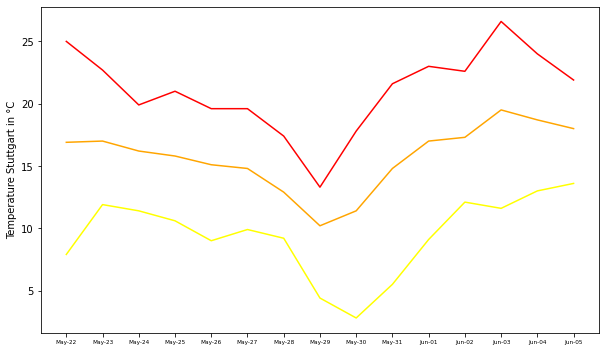

In [6]:
from typing import NamedTuple


class WeatherDatapoint(NamedTuple):
    date: datetime
    temp_avg: float
    temp_min: float
    temp_max: float


def _weather_data_date(date_string: str) -> datetime:
    return datetime.strptime(date_string, '%Y%m%d')


# May 22nd - June 5th, one datapoint a day
weather_data_stuttgart = [
    WeatherDatapoint(date=_weather_data_date('20220522'), temp_avg=16.9,
                     temp_min=7.9, temp_max=25.0),
    WeatherDatapoint(date=_weather_data_date('20220523'), temp_avg=17.0,
                     temp_min=11.9, temp_max=22.7),
    WeatherDatapoint(date=_weather_data_date('20220524'), temp_avg=16.2,
                     temp_min=11.4, temp_max=19.9),
    WeatherDatapoint(date=_weather_data_date('20220525'), temp_avg=15.8,
                     temp_min=10.6, temp_max=21.0),
    WeatherDatapoint(date=_weather_data_date('20220526'), temp_avg=15.1,
                     temp_min=9.0, temp_max=19.6),
    WeatherDatapoint(date=_weather_data_date('20220527'), temp_avg=14.8,
                     temp_min=9.9, temp_max=19.6),
    WeatherDatapoint(date=_weather_data_date('20220528'), temp_avg=12.9,
                     temp_min=9.2, temp_max=17.4),
    WeatherDatapoint(date=_weather_data_date('20220529'), temp_avg=10.2,
                     temp_min=4.4, temp_max=13.3),
    WeatherDatapoint(date=_weather_data_date('20220530'), temp_avg=11.4,
                     temp_min=2.8, temp_max=17.8),
    WeatherDatapoint(date=_weather_data_date('20220531'), temp_avg=14.8,
                     temp_min=5.5, temp_max=21.6),
    WeatherDatapoint(date=_weather_data_date('20220601'), temp_avg=17.0,
                     temp_min=9.1, temp_max=23.0),
    WeatherDatapoint(date=_weather_data_date('20220602'), temp_avg=17.3,
                     temp_min=12.1, temp_max=22.6),
    WeatherDatapoint(date=_weather_data_date('20220603'), temp_avg=19.5,
                     temp_min=11.6, temp_max=26.6),
    WeatherDatapoint(date=_weather_data_date('20220604'), temp_avg=18.7,
                     temp_min=13.0, temp_max=24.0),
    WeatherDatapoint(date=_weather_data_date('20220605'), temp_avg=18.0,
                     temp_min=13.6, temp_max=21.9),
]
weather_data_stuttgart_dates = [datapoint.date
                                for datapoint in weather_data_stuttgart]


def _base_plot_weather(name: str) -> (pyplot.Figure, pyplot.Axes):
    return base_plot(name, width_in=10.0, height_in=6.0,
                     x_axis_config=DateAxisConfig.ENTIRE_RANGE_DAILY)


def _plot_stuttgart_weather(axis: pyplot.Axes):
    min_data = [datapoint.temp_min for datapoint in weather_data_stuttgart]
    avg_data = [datapoint.temp_avg for datapoint in weather_data_stuttgart]
    max_data = [datapoint.temp_max for datapoint in weather_data_stuttgart]

    axis.set_ylabel('Temperature Stuttgart in °C')
    axis.plot(weather_data_stuttgart_dates, min_data, color='yellow')
    axis.plot(weather_data_stuttgart_dates, avg_data, color='orange')
    axis.plot(weather_data_stuttgart_dates, max_data, color='red')


weather_stuttgart_name = 'weather_stuttgart'
weather_stuttgart_fig, weather_stuttgart_ax = _base_plot_weather(
    weather_stuttgart_name)

_plot_stuttgart_weather(weather_stuttgart_ax)

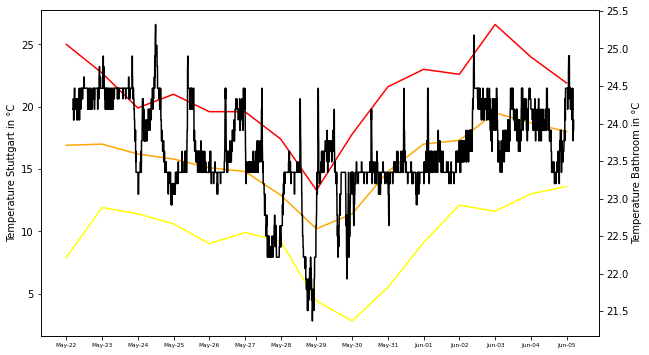

In [7]:
weather_vs_bathroom_temp_name = "weather_vs_bathroom_temp"
weather_vs_bathroom_temp_fig, weather_vs_bathroom_temp_ax = _base_plot_weather(
    weather_vs_bathroom_temp_name)
weather_vs_bathroom_temp_ax2: pyplot.Axes = weather_vs_bathroom_temp_ax.twinx()

_plot_stuttgart_weather(weather_vs_bathroom_temp_ax)

weather_vs_bathroom_temp_ax2.set_ylabel('Temperature Bathroom in °C')
weather_vs_bathroom_temp_ax2.plot(raw_data('sensors').timestamps(),
                                  bathroom_temperature_data, color='black')

The min/avg/max outside temperatures are colored.
The bathroom temperature is black or white.

#### As we can see: Yes! There is a correlation between the inside and outside temperatures.

---

# Presence

#### I'm interested how much time I spend in the bathroom on average...

This data will not be 100% accurate as other people use my bathroom too :(

Time spent in bathroom on average: 60 min


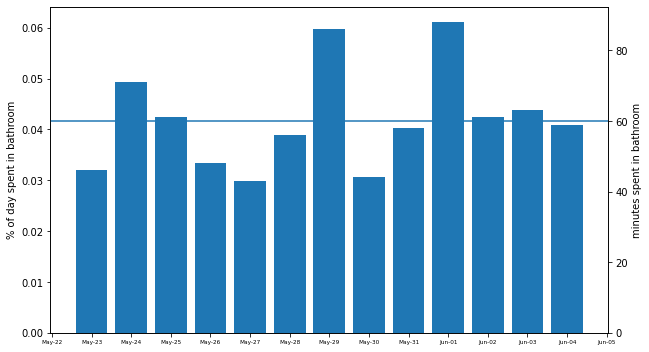

In [8]:
daily_bathroom_presence_data_percent = (raw_data('sensors')
                                        .device_data_of('Sensor Badezimmer')
                                        .avg_daily(lambda x: x.state.presence))
daily_bathroom_presence_dates = [x[0] for x in
                                 daily_bathroom_presence_data_percent]
daily_bathroom_presence_percents = [y[1] for y in
                                    daily_bathroom_presence_data_percent]
daily_bathroom_presence_minutes = [int(percent * 60 * 24) for percent in
                                   daily_bathroom_presence_percents]
daily_bathroom_presence_avg = int(
    sum(daily_bathroom_presence_minutes)
    / len(daily_bathroom_presence_minutes))

daily_bathroom_presence_fig, daily_bathroom_presence_ax = base_plot(
    'daily_bathroom_presence', width_in=10.0, height_in=6.0,
    x_axis_config=DateAxisConfig.ENTIRE_RANGE_DAILY)
daily_bathroom_presence_ax2: pyplot.Axes = daily_bathroom_presence_ax.twinx()

daily_bathroom_presence_ax.set_ylabel('% of day spent in bathroom')
daily_bathroom_presence_ax.bar(daily_bathroom_presence_dates,
                               daily_bathroom_presence_percents)

daily_bathroom_presence_ax2.set_ylabel('minutes spent in bathroom')
daily_bathroom_presence_ax2.bar(daily_bathroom_presence_dates,
                                daily_bathroom_presence_minutes)
daily_bathroom_presence_ax2.axhline(daily_bathroom_presence_avg)

print(f'Time spent in bathroom on average: {daily_bathroom_presence_avg} min')

#### An hour a day, that's quite some time...

---

# Other ideas

#### That's it for this project, but I have more ideas that I might have done if I had more time:

- Calculating / plotting data about power usage of the lights
- Plotting the on/off states of the lights in the bathroom vs. the present/not present signal of the presence sensor -> do they match exactly?
- Plotting the battery states of the presence sensor and the dimmer switch